<a href="https://colab.research.google.com/github/ziatdinovmax/GPim/blob/master/examples/notebooks/GP_2D3D_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gaussian processes for sparse 2D and 3D imaging

Prepared by Maxim Ziatdinov (March 2020)

E-mail: maxim.ziatdinov@ai4microscopy.com

---

This notebook applies Gaussian process regression for reconstructing sparse/corrupted 2D microscopy scans and 3D hperspectral data.

---



In [ ]:
#@title Install/Import modules { form-width: "20%" }
# Install GPim
!python3 -m pip install -q gpim
# Imports
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import gpim
import torch
import warnings
warnings.filterwarnings("ignore", module="gpytorch.utils.interpolation")
# download training data
!wget -qq -O 'spiral_scans_2d.npy' 'https://github.com/ziatdinovmax/GPim/blob/master/expdata/spiral_s_00010_2019.npy?raw=true'
!wget -qq -O 'graphene_twist_2d.npy' 'https://github.com/ziatdinovmax/GPim/blob/master/expdata/graphene-twist-simulated.npy?raw=true'
!wget -qq -O 'sparse_hyper_3d.npy' 'https://github.com/ziatdinovmax/GPim/blob/master/expdata/bepfm_test_data.npy?raw=true'

Read and plot sparse 2D image data:

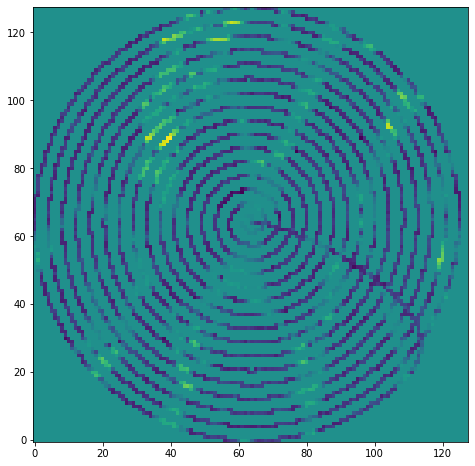

In [2]:
imgdata = np.load('spiral_scans_2d.npy')
plt.figure(figsize=(8, 8))
plt.imshow(imgdata, origin='bottom');

Normalize and assign NaNs to regions with no data:

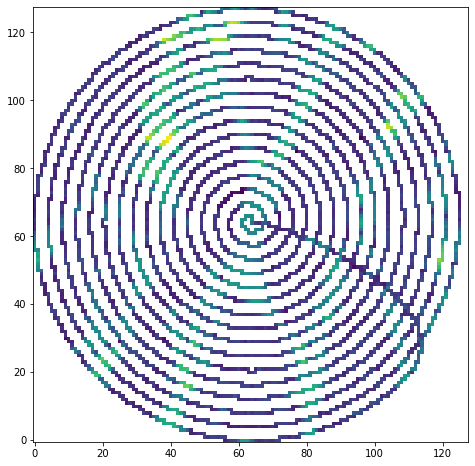

In [3]:
R = (imgdata - np.min(imgdata)) / np.ptp(imgdata)
R[R == R[1, 1]] = np.nan # Take value at [1, 1] as missing data value
plt.figure(figsize=(8, 8))
plt.imshow(R, origin='bottom');

Prepare data for GP regression. We are going to use a sparse grid ```X``` for model training and a full grid ```X_true``` for "testing"/prediction.

In [4]:
X_full = gpim.utils.get_full_grid(R) # get full grid indices
X_sparse = gpim.utils.get_sparse_grid(R) # get sparse grid indices

We will now run the GP regression for reconstructing the image from the sparse scan. Notice that by varying parameters such as ```indpoints```, ```learning_rate``` and ```iterations```, you can vary the model training time between seconds and minutes.

Model training...
average time per iteration: 0.052300000000000006 s
training completed in 15.2 s
Final parameter values:
 amp: 0.048, lengthscale: [3.8383 2.9884], noise: 0.0056217
Calculating predictive mean and variance... Done


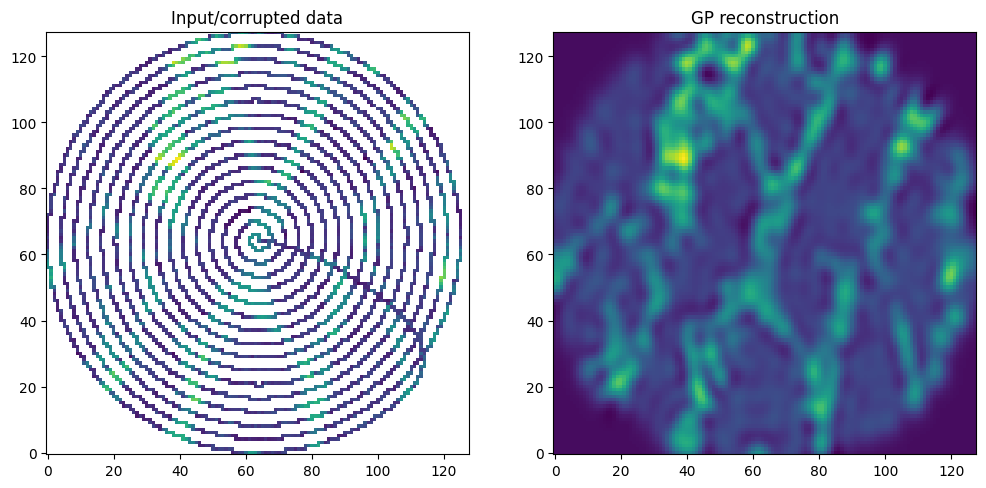

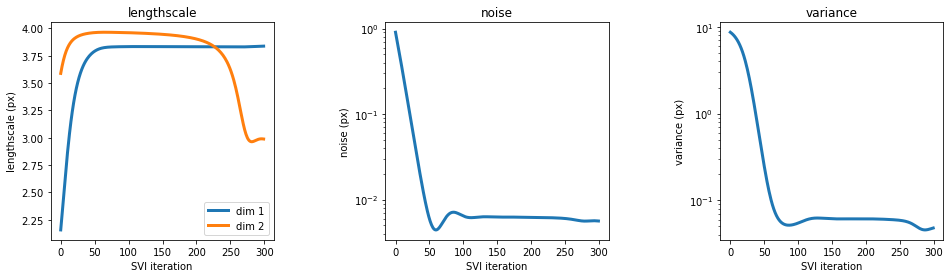

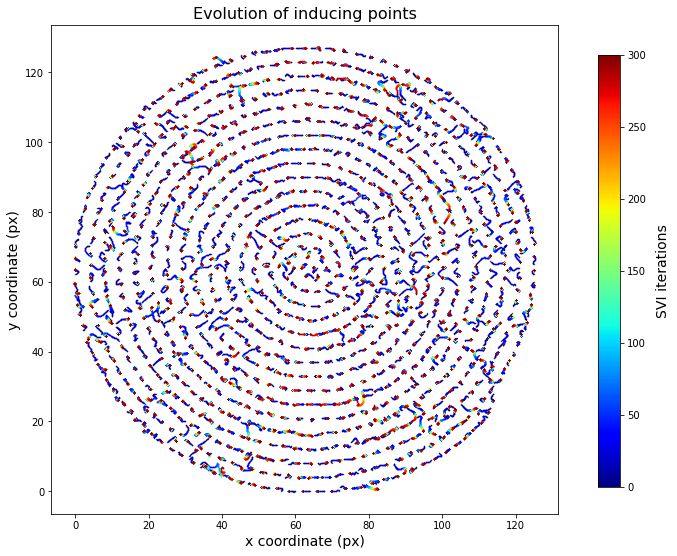

In [5]:
# type of kernel ('RBF', 'Matern52' or 'RationalQuadratic')
kernel = 'RBF'
# lengthscale constraints
lscale = [[1., 1.], [4., 4.]]
# Initiate and run GP reconstruction
reconstructor = gpim.reconstructor(
    X_sparse, R, X_full, # training input, training output, test input
    kernel, lengthscale=lscale, # GP kernel and lengthscale constraints
    sparse=True, indpoints=1000, # Run sparse GP with 1000 inducing points
    learning_rate=0.1, iterations=300, # learning rate and number of SVI steps
    use_gpu=True, verbose=1 # GPU acceleration and verbosisty
)
mean, sd, hyperparams = reconstructor.run()
# Plot results and evolution of kernel hyperparameters during training
gpim.utils.plot_reconstructed_data2d(R, mean, cmap='viridis')
gpim.utils.plot_kernel_hyperparams(hyperparams)
gpim.utils.plot_inducing_points(hyperparams)

We can also use [structured kernel](http://proceedings.mlr.press/v37/wilson15.pdf) GP approach, which generally allows fitting more "inducing points" into memory and can produce a higher quality reconstruction on larger datasets:

Model training...
average time per iteration: 0.209 s
training completed in 34.54 s
Final parameter values:
 lengthscale: [2.7006 2.7006], noise: 0.0024742
Calculating predictive mean and uncertainty...
Batch 1/1
Done


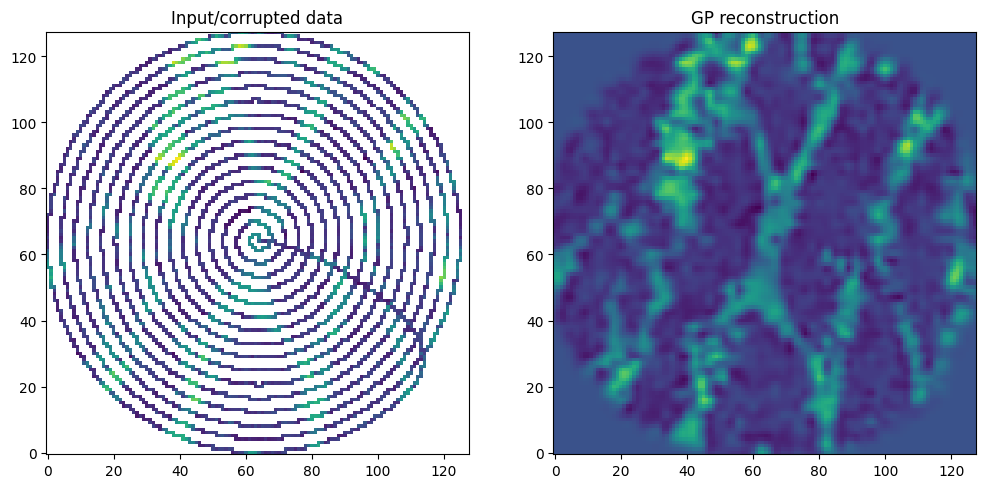

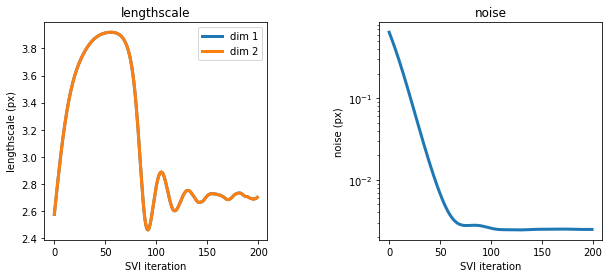

In [6]:
# Initiate and run GP reconstruction
skreconstructor = gpim.skreconstructor(
    X_sparse, R, X_full, 
    kernel, lengthscale=lscale,
    learning_rate=0.1, iterations=200,
    use_gpu=True, verbose=1
)
mean, sd, hyperparams = skreconstructor.run()
# Plot results and evolution of kernel hyperparameters during training
gpim.utils.plot_reconstructed_data2d(R, mean, cmap='viridis')
gpim.utils.plot_kernel_hyperparams(hyperparams)

To reconstruct periodic data with missing structural elements, we may use [spectral mixture kernel](https://arxiv.org/pdf/1302.4245.pdf). Let's load an image of bilayer graphene where two misoriented layers create a Moire pattern:

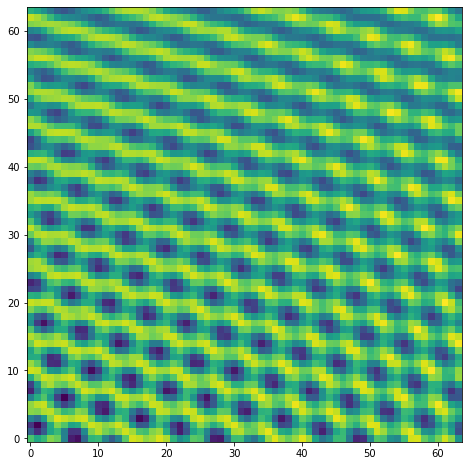

In [7]:
R_true = np.load("graphene_twist_2d.npy")
plt.figure(figsize=(8, 8))
plt.imshow(R_true, origin="bottom");

Corrupt the image and define the full and sparse grids:

In [8]:
R = R_true.copy()
R[30:60, 30:60] = np.nan # corrupt data
X_full = gpim.utils.get_full_grid(R) # get full grid indices
X_sparse = gpim.utils.get_sparse_grid(R) # get sparse grid indices

We next run GP reconstruction with the spectral mixture kernel.

Model training...
iter: 0 ... loss: 1.1507 ... noise: 0.6444967 ...
weight          mean          scale
0.0251  [ 5.9047 20.6273]  [5.9186 5.6523]
0.0251  [2.0438 1.9513]  [6.2739 9.4564]
0.0251  [ 5.01   20.8541]  [3.6715 5.1154]
0.0251  [16.3024  2.3626]  [ 3.4892 12.5984]
0.0251  [6.0547 2.5521]  [4.212  1.4134]
0.0251  [4.6368 2.8489]  [2.2737 8.2109]
iter: 10 ... loss: 0.4456 ... noise: 0.2872333 ...
weight          mean          scale
0.0134  [10.5235 48.7228]  [2.6279 6.3039]
0.0102  [ 5.2103 27.6307]  [9.4453 8.2106]
0.0101  [1.9819 1.8986]  [10.0306 15.1583]
0.0099  [42.1044  2.6351]  [ 5.5987 20.2243]
0.0096  [11.2676  3.2314]  [ 3.4794 13.188 ]
0.0094  [13.0882  4.5557]  [3.0394 1.1278]
average time per iteration: 0.41 s
iter: 20 ... loss: -0.0386 ... noise: 0.1095388 ...
weight          mean          scale
0.0116  [ 16.4777 120.0684]  [ 2.9502 10.4061]
0.007  [ 5.2097 20.4498]  [15.7068 13.4979]
0.0046  [1.9741 1.666 ]  [14.9204 23.6073]
0.0046  [105.1436   2.4641]  [ 8.960

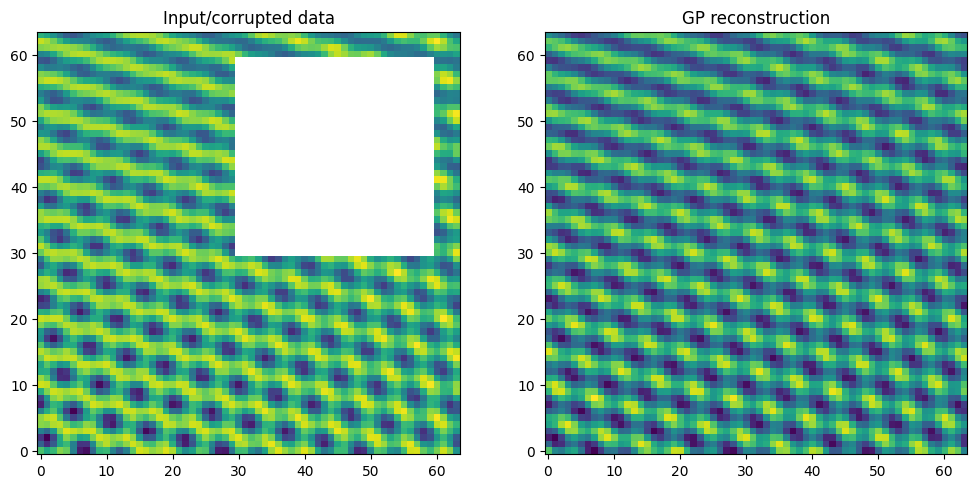

Mixture (final) weights:
Component 0: w = 0.00626
Component 1: w = 6e-05
Component 2: w = 0.02125
Component 3: w = 0.00017
Component 4: w = 5e-05
Component 5: w = 1e-05


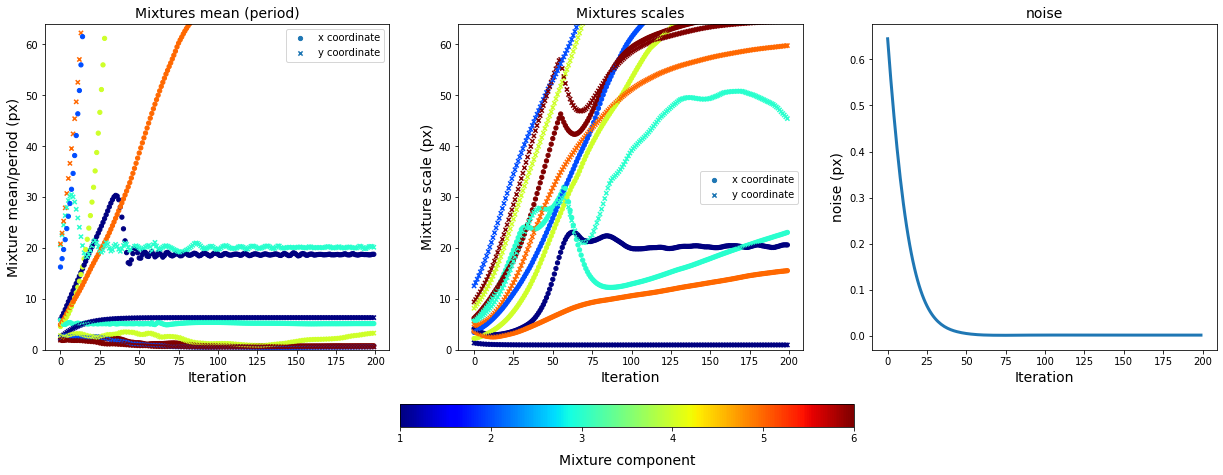

In [9]:
# Initiate and run GP reconstruction
skreconstructor = gpim.skreconstructor(
    X_sparse, R, X_full, 
    kernel="Spectral", n_mixtures=6,
    learning_rate=0.1, iterations=200,
    use_gpu=True, verbose=2
)
mean, sd, hyperparams = skreconstructor.run()
# Plot results and evolution of kernel hyperparameters during training
gpim.utils.plot_reconstructed_data2d(R, mean, cmap='viridis')
gpim.utils.plot_kernel_hyperparams(hyperparams)

## 3D sparse hyperspectral data

We next demonstratre how to apply GP to the reconstruction of sparse 3D hyperspectral dataset.

Load 3D dataset:

In [10]:
imgdata3d = np.load('sparse_hyper_3d.npy')
R_true = (imgdata3d - np.amin(imgdata3d))/np.ptp(imgdata3d)

Do some simple visualization:

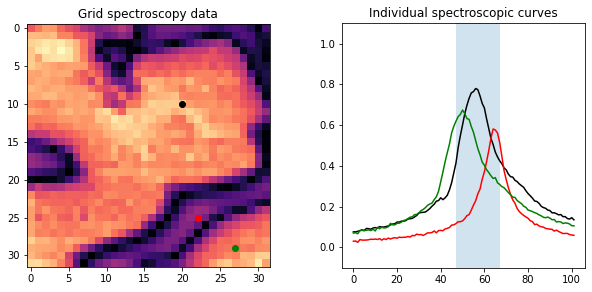

In [11]:
# choose slice
slice_number = 57
# size of window for averaging
spectral_window = 10
# select cooordinates for individual spectroscopic curves
pos = [
       [10, 20], 
       [25, 22], 
       [29, 27],
]
# plot
gpim.utils.plot_raw_data(R_true, slice_number, pos, spectral_window, norm=True)

We corrupt data by removing certain percentage of the observations (i.e. removing the entire spectroscopic curves from random xy locations):

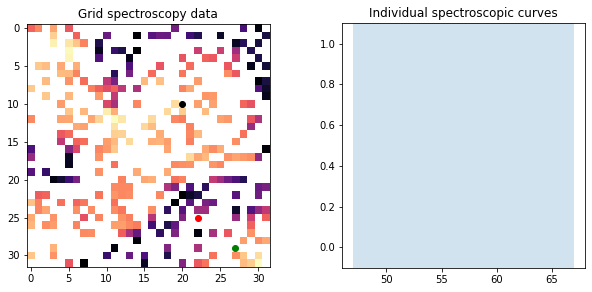

In [12]:
remove_obs = 0.7 # remove 70 % of the data

# Store "true" grid indices before removing parts of the data
X_true = gpim.utils.get_full_grid(R_true)
# Remove observations and plot the new "corrupted" data
X, R = gpim.utils.corrupt_data_xy(X_true, R_true, prob=remove_obs)
gpim.utils.plot_raw_data(R, slice_number, pos, spectral_window, norm=True)

We now run GP regression on the corrupted data to reconstruct the original signal:

(This may take some some on older GPUs such as Tesla K80)

In [13]:
lengthscale_ = [[1., 1., 1.], [20., 20., 20.]]

reconstr = gpim.reconstructor(
    X, R, X_true, kernel='Matern52', lengthscale=lengthscale_, 
    sparse=True, indpoints=1000, learning_rate=0.1, iterations=500, 
    use_gpu=True, verbose=2
)
mean, sd, hyperparams = reconstr.run()

# of inducing points for sparse GP regression: 1024
Model training...
iter: 0 ... loss: 56663.2848 ... amp: 8.6959 ... length: [ 8.3244 17.3963  3.7983] ... noise: 1.1051709 ...
iter: 100 ... loss: -44936.4832 ... amp: 0.3975 ... length: [12.576  19.549  16.6097] ... noise: 0.0027713 ...
average time per iteration: 0.20829999999999999 s
iter: 200 ... loss: -55292.1258 ... amp: 0.0116 ... length: [ 3.2128  4.937  18.4896] ... noise: 0.0011057 ...
iter: 300 ... loss: -55576.2142 ... amp: 0.0117 ... length: [ 3.1236  4.8435 18.5028] ... noise: 0.0010543 ...
iter: 400 ... loss: -55474.6239 ... amp: 0.0119 ... length: [ 3.1058  4.8281 18.492 ] ... noise: 0.0010601 ...
iter: 499 ... loss: -55441.4562 ... amp: 0.0118 ... length: [ 3.1001  4.793  18.4733] ... noise: 0.001063 ...
training completed in 103.11 s
Final parameter values:
 amp: 0.0118, lengthscale: [ 3.1001  4.793  18.4733], noise: 0.001063
Calculating predictive mean and variance... Done


Plot the evolution of hyperparameters during the training:

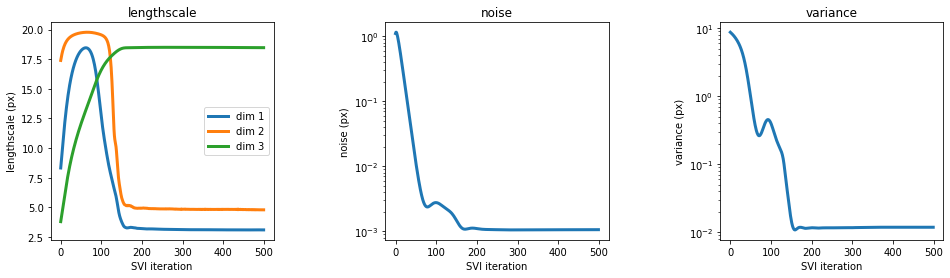

In [14]:
gpim.utils.plot_kernel_hyperparams(hyperparams)

Plot the evolution of inducing points:

(may take up to ~1 minute)

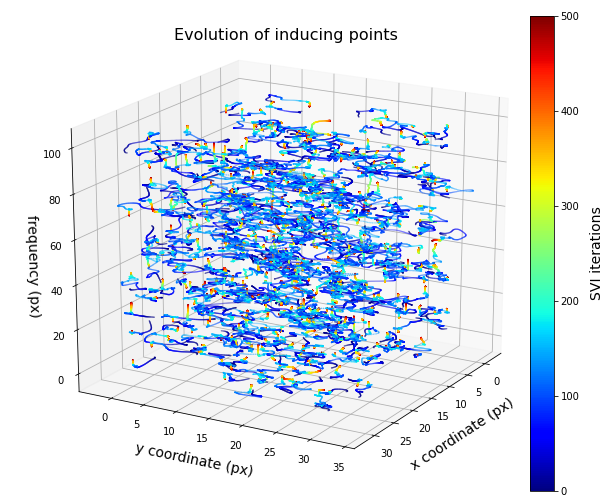

In [15]:
gpim.utils.plot_inducing_points(hyperparams, slice_step=2)

Plot the results:

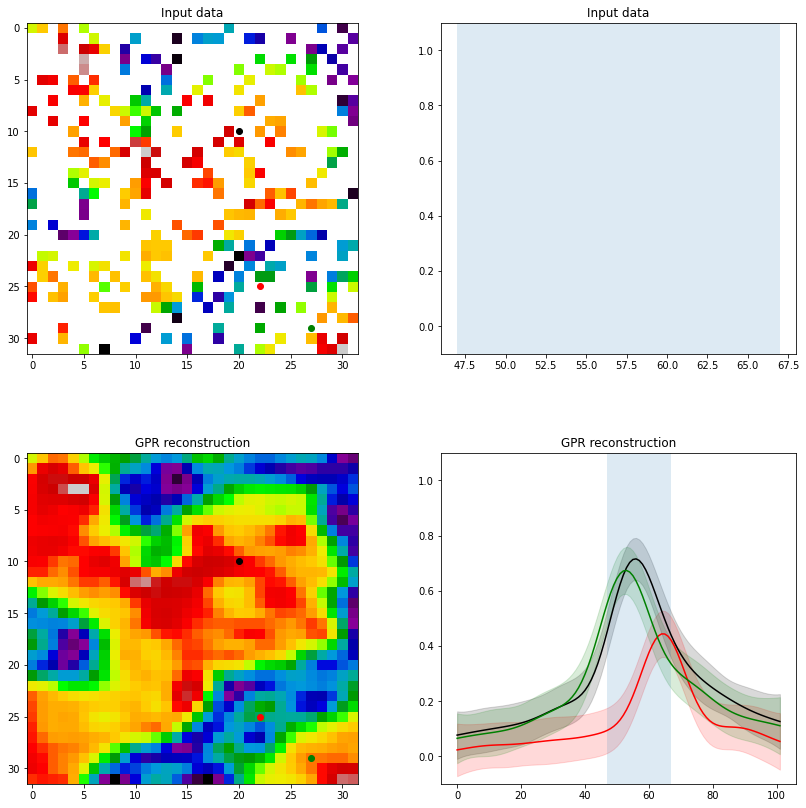

In [16]:
gpim.utils.plot_reconstructed_data3d(R, mean, sd, slice_number, pos, spectral_window)

Looks like even with ~70 % of observations removed we were able to reconstruct the original signal pretty accurately!